<a href="https://colab.research.google.com/github/AshwinPradeep01/ForestLandDetection/blob/main/ForestLandDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install kaggle

In [22]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [23]:
!kaggle datasets download --force -d nilesh789/eurosat-rgb

 87% 78.0M/89.6M [00:00<00:00, 189MB/s]
100% 89.6M/89.6M [00:00<00:00, 181MB/s]


In [ ]:
!unzip /content/eurosat-rgb.zip

In [51]:
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import shutil

from sklearn import ensemble
from sklearn.metrics import accuracy_score

In [34]:
LABELS = os.listdir("/content/2750")
print(LABELS)

['HerbaceousVegetation', 'Forest', 'Pasture', 'Industrial', 'Highway', 'River', 'SeaLake', 'PermanentCrop', 'Residential', 'AnnualCrop']


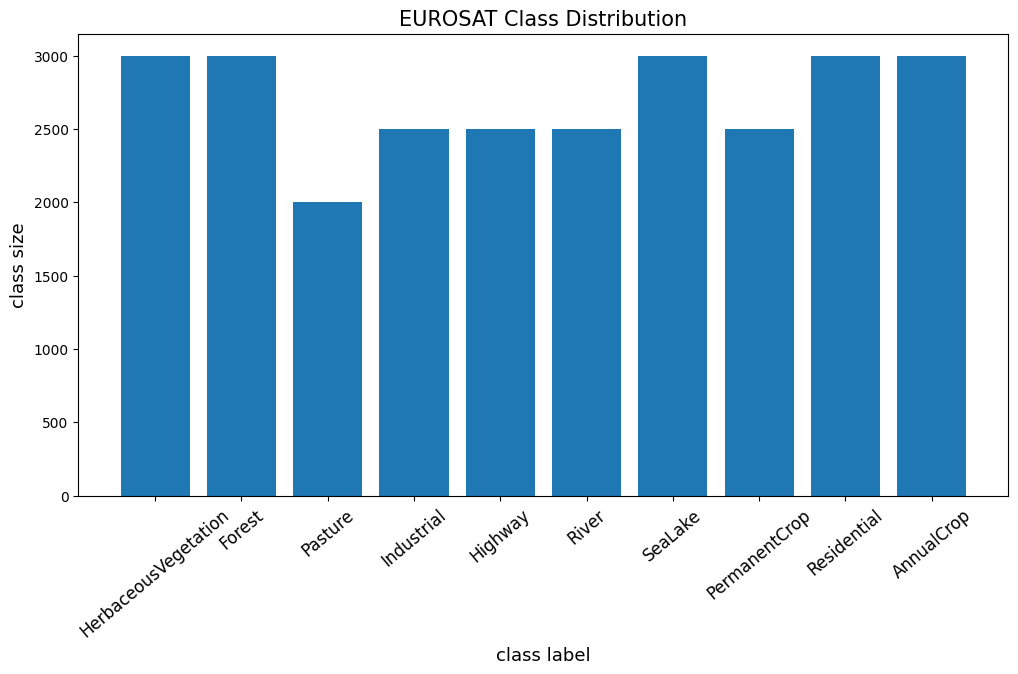

In [35]:
counts = {}

DATASET ='/content/2750'
for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))


plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

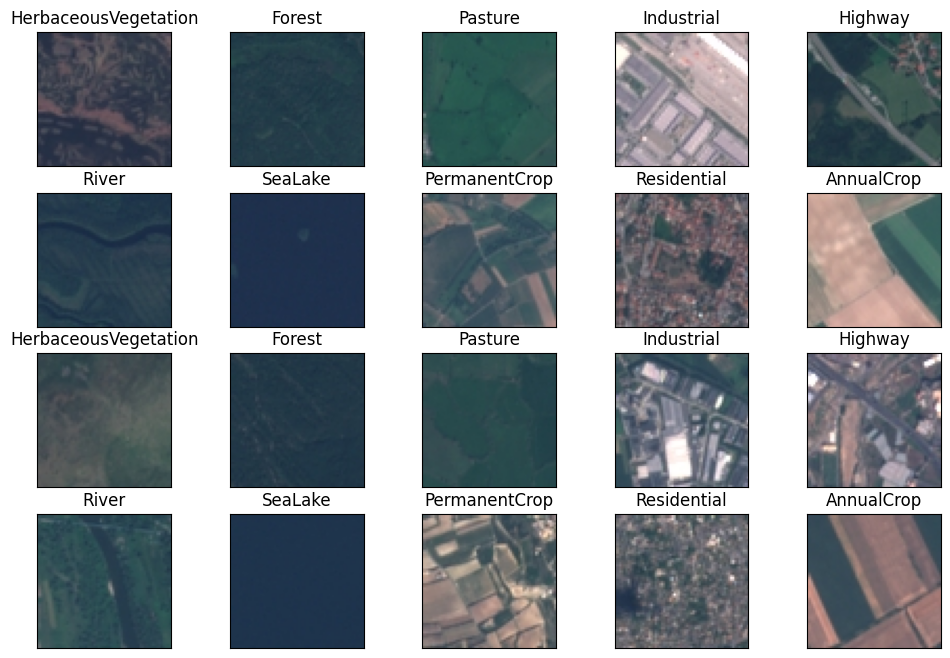

In [28]:
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(12, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

In [31]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '/content/training'
TEST_DIR = '/content/testing'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:

    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [44]:
# map each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):

    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('/content/2750',TRAIN_DIR, i) for i in train_paths]
    new_test_paths = [re.sub('/content/2750', TEST_DIR, i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))

    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

moving training files..


100%|██████████| 21600/21600 [00:06<00:00, 3376.96it/s]


moving testing files..


100%|██████████| 5400/5400 [00:01<00:00, 4670.52it/s]


In [45]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)

# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [46]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [47]:
np.save('class_indices', train_generator.class_indices)

## **Random Forest Classifier**

In [48]:
# Using image data generator api in keras for making image dataset
rf_gen = ImageDataGenerator(rescale=1./255)

rf_train_generator = rf_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    # by using batch_size as training data size we can extract data from this iterator
    batch_size=21600,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

rf_test_generator = rf_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=5400,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [49]:
train = rf_train_generator.next()
X_train = train[0].reshape(21600, 12288)
y_train = train[1]

test = rf_test_generator.next()
X_test = test[0].reshape(5400, 12288)
y_test = test[1]

In [50]:
# Creating mini batches of training data as training on whole data is difficult
ids_1 = np.random.choice(len(X_train), size=21600, replace=False)
X_train_mini_1 = X_train[ids_1]
y_train_mini_1 = rf_train_generator.classes[ids_1]

In [52]:
rf = ensemble.RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=7)
rf.fit(X_train_mini_1, y_train_mini_1)
y_pred = rf.predict(X_test)
acc = accuracy_score(y_pred, rf_test_generator.classes)
print("Accuracy Score: {0:.4}".format(acc))

Accuracy Score: 0.6215


In [54]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam


from keras.applications import VGG16
from keras.applications import ResNet50
from keras.applications import InceptionV3, Xception

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [56]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_soft_device_placement(True)

In [77]:
# Note that for different CNN models we are using different setup of dense layers
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):

    if (cnn_base == 'ResNet50'):
            conv_base = ResNet50(include_top=False,
                                 weights='imagenet',
                                 input_shape=input_shape)
            top_model = conv_base.output
            top_model = Flatten()(top_model)
            top_model = Dense(2048, activation='relu')(top_model)
            top_model = Dropout(0.2)(top_model)
    elif (cnn_base == 'VGG16'):
            conv_base = VGG16(include_top=False,
                              weights='imagenet',
                              input_shape=input_shape)

            top_model = conv_base.output
            top_model = Flatten()(top_model)
            top_model = Dense(2048, activation='relu')(top_model)
            top_model = Dropout(0.2)(top_model)
            top_model = Dense(2048, activation='relu')(top_model)
            top_model = Dropout(0.2)(top_model)


    output_layer = Dense(n_classes, activation='softmax')(top_model)

    model = Model(inputs=conv_base.input, outputs=output_layer)

    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])

    return model

In [78]:
def plot_history(history):

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    plt.show();

In [79]:
def display_results(y_true, y_preds, class_labels):

    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)

    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds),
                            columns=class_labels,
                            index=class_labels)
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")
    return results, conf_mat

In [80]:
def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]

        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

In [81]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 20

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

## **ResNet50**

In [82]:
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)resnet50_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [83]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [85]:
# First Pretraining the dense layer
resnet50_history = resnet50_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=10,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/10


<ipython-input-85-9100fd547d6c>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet50_history = resnet50_model.fit_generator(train_generator,


337/337 [==============================] - ETA: 0s - loss: 1.5496 - categorical_accuracy: 0.4150
Epoch 1: val_categorical_accuracy improved from 0.39528 to 0.41722, saving model to /content/model.weights.best.hdf5
337/337 [==============================] - 63s 186ms/step - loss: 1.5496 - categorical_accuracy: 0.4150 - val_loss: 1.4863 - val_categorical_accuracy: 0.4172
Epoch 2/10
337/337 [==============================] - ETA: 0s - loss: 1.4895 - categorical_accuracy: 0.4362
Epoch 2: val_categorical_accuracy improved from 0.41722 to 0.49349, saving model to /content/model.weights.best.hdf5
337/337 [==============================] - 60s 178ms/step - loss: 1.4895 - categorical_accuracy: 0.4362 - val_loss: 1.3848 - val_categorical_accuracy: 0.4935
Epoch 3/10
337/337 [==============================] - ETA: 0s - loss: 1.4530 - categorical_accuracy: 0.4545
Epoch 3: val_categorical_accuracy did not improve from 0.49349
337/337 [==============================] - 50s 147ms/step - loss: 1.4530 -

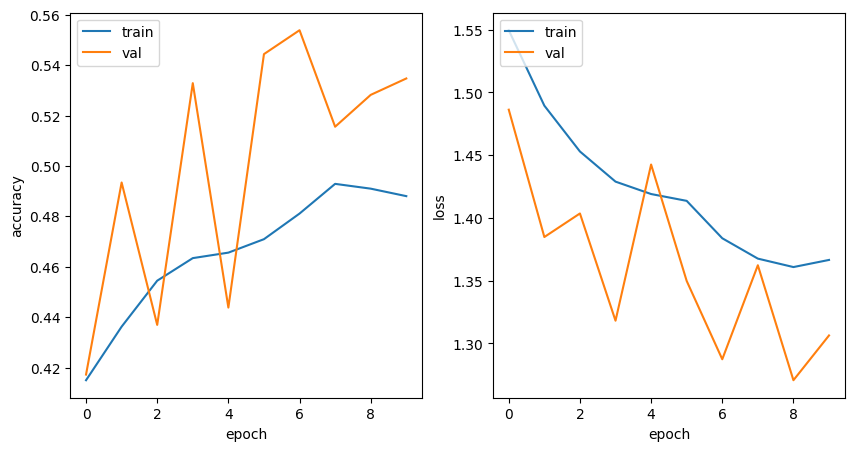

In [89]:
plot_history(resnet50_history)

In [90]:
resnet50_model.load_weights('/content/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet50_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.


<ipython-input-90-642abdfcc187>:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = resnet50_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))


Accuracy: 0.24462962962962964
Global F2 Score: 0.24462962962962964


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,F-Score,Support
AnnualCrop,0.134427,0.983333,0.236520,600.0
Forest,0.000000,0.000000,0.000000,600.0
HerbaceousVegetation,0.000000,0.000000,0.000000,600.0
Highway,0.000000,0.000000,0.000000,500.0
Industrial,0.854167,0.738000,0.791845,500.0
Pasture,0.000000,0.000000,0.000000,400.0
PermanentCrop,0.000000,0.000000,0.000000,500.0
Residential,0.625216,0.603333,0.614080,600.0
River,0.000000,0.000000,0.000000,500.0
SeaLake,0.000000,0.000000,0.000000,600.0


In [91]:
resnet50_model.save('/content/ResNet50_eurosat.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## **VGG16**

In [92]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
vgg16_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                            

In [93]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=10,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

<ipython-input-94-28b6288db749>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg16_history = vgg16_model.fit_generator(train_generator,


Epoch 1/10
337/337 [==============================] - ETA: 0s - loss: 0.8949 - categorical_accuracy: 0.6813
Epoch 1: val_categorical_accuracy improved from -inf to 0.78962, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 65s 185ms/step - loss: 0.8949 - categorical_accuracy: 0.6813 - val_loss: 0.6140 - val_categorical_accuracy: 0.7896
Epoch 2/10
337/337 [==============================] - ETA: 0s - loss: 0.6660 - categorical_accuracy: 0.7667
Epoch 2: val_categorical_accuracy improved from 0.78962 to 0.80283, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 53s 157ms/step - loss: 0.6660 - categorical_accuracy: 0.7667 - val_loss: 0.5738 - val_categorical_accuracy: 0.8028
Epoch 3/10
337/337 [==============================] - ETA: 0s - loss: 0.6178 - categorical_accuracy: 0.7814
Epoch 3: val_categorical_accuracy improved from 0.80283 to 0.81101, saving model to ../working/model.weights.best.hdf5
337/33

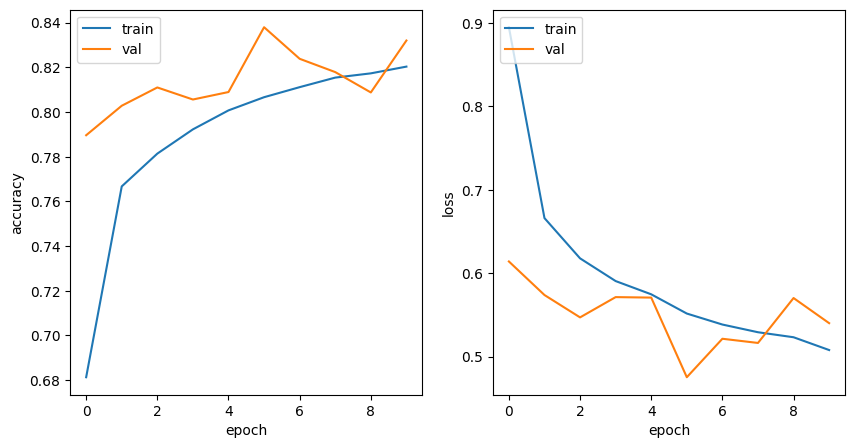

In [98]:
plot_history(vgg16_history)

In [96]:
vgg16_model.load_weights('/content/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.


<ipython-input-96-39c94c5656df>:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = vgg16_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))


Accuracy: 0.815
Global F2 Score: 0.815


,Precision,Recall,F-Score,Support
AnnualCrop,0.570988,0.925000,0.706107,600.0
Forest,0.869173,0.963333,0.913834,600.0
HerbaceousVegetation,0.917226,0.683333,0.783190,600.0
Highway,0.758621,0.660000,0.705882,500.0
Industrial,0.896353,0.934000,0.914789,500.0
Pasture,0.856734,0.747500,0.798398,400.0
PermanentCrop,0.869081,0.624000,0.726426,500.0
Residential,0.821378,0.973333,0.890923,600.0
River,0.839329,0.700000,0.763359,500.0
SeaLake,0.984733,0.860000,0.918149,600.0


In [97]:
vgg16_model.save('/content/vgg16_eurosat.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
